In [24]:
from skimage import io, filters
import matplotlib.pyplot as plt
import numpy as np

**Example image read as grayscale**

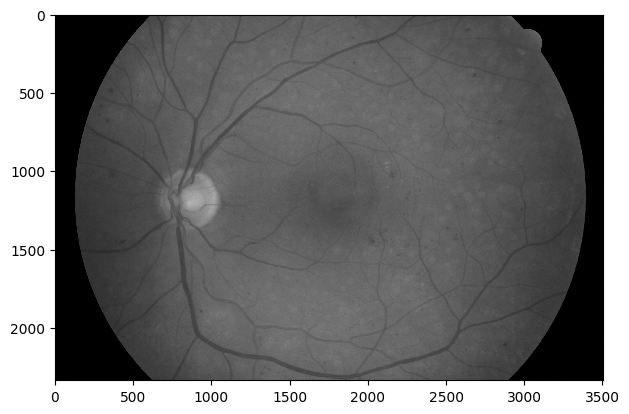

In [25]:
image = io.imread("images/01_dr.JPG", as_gray=True)
io.imshow(image)

**Display comparison of rgb channels**

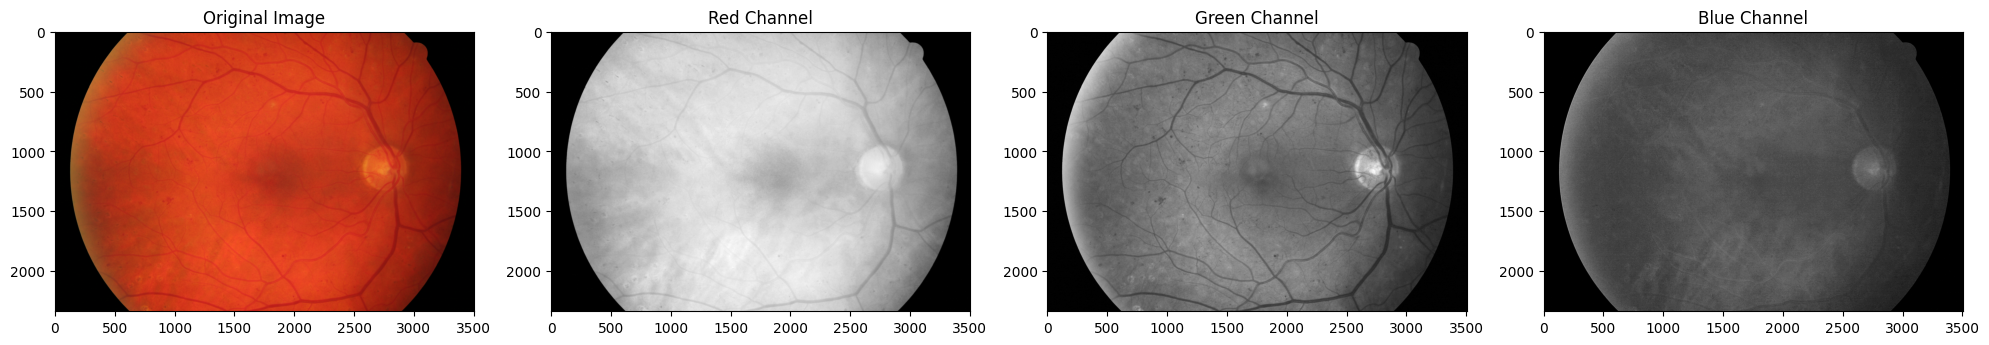

In [26]:
image_name = 'images/02_dr.JPG'
gold_standard_name = 'manual1/02_dr.tif'
mask_name = 'mask/02_dr_mask.tif'
image = io.imread(image_name)

# Separate the color channels
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

# Display the original and separated channels
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
ax = axes.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image')

ax[1].imshow(red_channel, cmap='gray')
ax[1].set_title('Red Channel')

ax[2].imshow(green_channel, cmap='gray')
ax[2].set_title('Green Channel')

ax[3].imshow(blue_channel, cmap='gray')
ax[3].set_title('Blue Channel')
plt.tight_layout()

**Apply gaussian and frangi filters**

In [27]:
from skimage import io, filters

blurred_green = filters.gaussian(green_channel, sigma=5)
filtered_green = filters.frangi(blurred_green)

**We'll use only green rgb channel**

0.0 0.7515567483134961


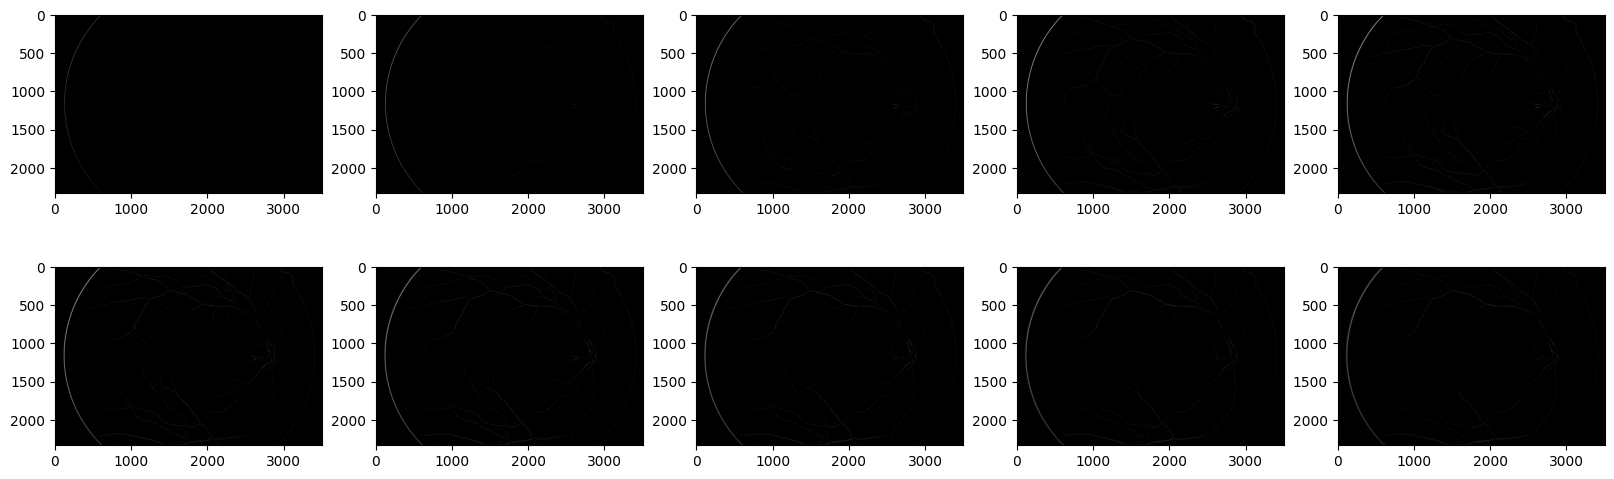

In [28]:
fig, ax = plt.subplots(2, 5, figsize=(20, 6))

for i in range(10):
    # Sprawdzamy jak wygląda obraz dla różnej wartości odchylenia standardowego oraz po użyciu filtru frangi'ego
    gaussian_filtered = filters.gaussian(green_channel, sigma=i+1)
    frangi_filtered = filters.frangi(gaussian_filtered)
    if i < 5: ax[0][i%5].imshow(frangi_filtered, cmap='gray')
    if i >= 5: ax[1][i%5].imshow(frangi_filtered, cmap='gray')

import numpy as np
print(np.min(filtered_green), np.max(filtered_green))


**Perform gaussian and frangi filters**

In [29]:
gaussian_filtered = filters.gaussian(green_channel, 10)
frangi_filtered = filters.frangi(gaussian_filtered)

**Scale image to 0, 1 pixel range**

In [30]:
original_min = 0.0
original_max = np.max(frangi_filtered)
target_min = 0.0
target_max = 1.0

scaled_array = (frangi_filtered - original_min) * ((target_max - target_min) / (original_max - original_min)) + target_min

**Apply mask**

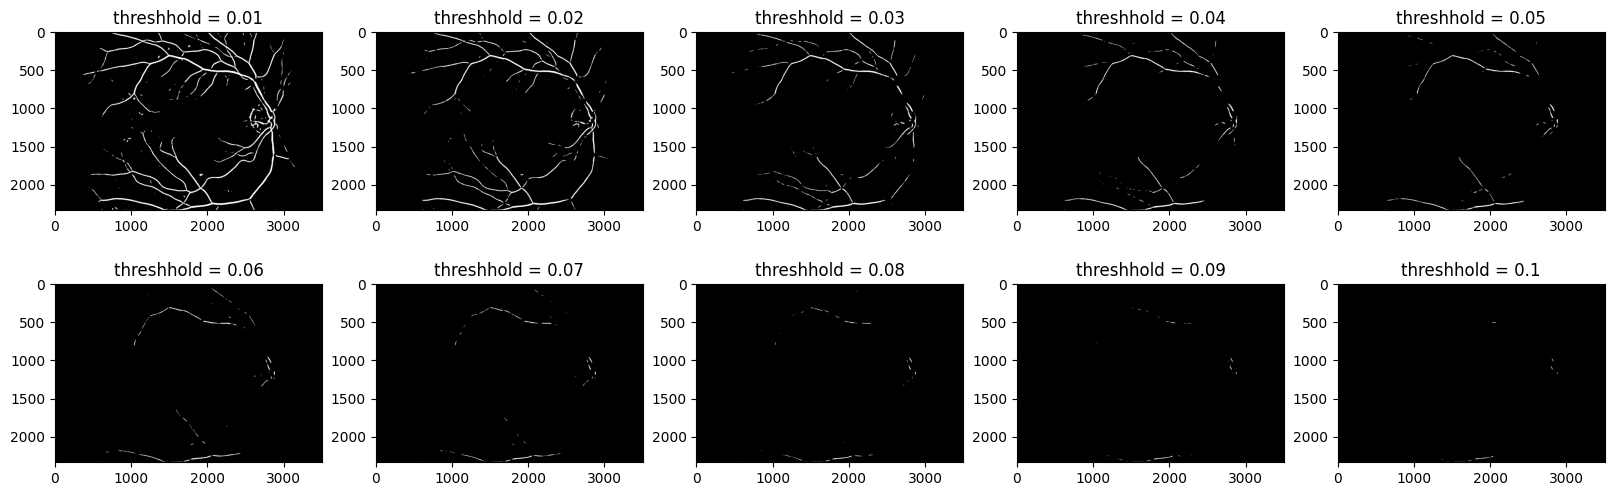

In [31]:

mask = io.imread(mask_name, plugin='tifffile', as_gray=True)

# Przeskalowanie maski
for i in range(len(mask)):
    for j in range(len(mask[0])):
        if mask[i][j] == 255: mask[i][j] = 1

res = np.zeros(mask.shape)
for i in range(len(res)):
    for j in range(len(res[0])):
        if mask[i][j] == 1: res[i][j] = scaled_array[i][j]

fig, ax = plt.subplots(2, 5, figsize=(20, 6))

for i in range(10):
    threshholded_image = res > 0.01 * (i+1)
    if i < 5: 
        ax[0][i%5].imshow(threshholded_image, cmap='gray')
        ax[0][i%5].set_title(f'threshhold = {(i+1)*0.01}')
    if i >= 5: 
        ax[1][i%5].imshow(threshholded_image, cmap='gray')
        ax[1][i%5].set_title(f'threshhold = {(i+1)*0.01}')

**Apply threshholding**

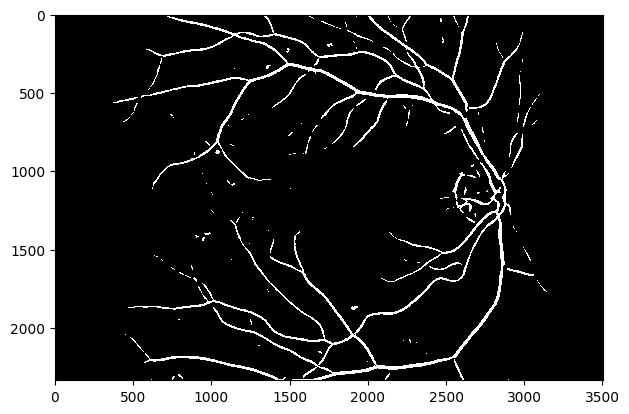

In [32]:
threshholded_image = res > 0.01
io.imshow(threshholded_image)

**Compare result with gold standard and display statistics**

In [33]:
# res vs gold standard
prediction = threshholded_image
gold_standard = io.imread(gold_standard_name)
for i in range(len(gold_standard)):
    for j in range(len(gold_standard[0])):
        if gold_standard[i][j] == 255: gold_standard[i][j] = 1


def calculate_accuracy(predictions, ground_truth):
    count = 0
    for i in range(len(predictions)):
        for j in range(len(predictions[0])):
            if predictions[i][j] == ground_truth[i][j]: count += 1
    num_pixels = predictions.shape[0] * predictions.shape[1]
    accuracy = count / num_pixels * 100
    return accuracy

def calculate_sensitivity(predictions, ground_truth):
    #prawdziwie pozytywne / (prawdziwie pozytywne + fałszywie negatywne)
    TP = 0
    FN = 0
    for i in range(len(predictions)):
        for j in range(len(predictions[0])):
            if ground_truth[i][j] == 1 and predictions[i][j] == 1: TP += 1
            if ground_truth[i][j] == 1 and predictions[i][j] == 0: FN += 1
    
    sensitivity = TP / (TP + FN)
    return sensitivity

def calculate_specificity(predictions, ground_truth):
    #prawdziwie negatywne / prawdziwie negatywne + fałszywie pozytywne
    TN = 0
    FP = 0
    for i in range(len(predictions)):
        for j in range(len(predictions[0])):
            if ground_truth[i][j] == 0 and predictions[i][j] == 0: TN += 1
            if ground_truth[i][j] == 0 and predictions[i][j] == 1: FP += 1

    specificity = TN / (TN + FP)
    return specificity

acc = calculate_accuracy(prediction, gold_standard)
sens = calculate_sensitivity(prediction, gold_standard)
spec = calculate_specificity(prediction, gold_standard)
print(acc)
print(sens)
print(spec)

95.92040358963533
0.5500959994481469
0.9870640777945645


**Processed image vs gold standard**

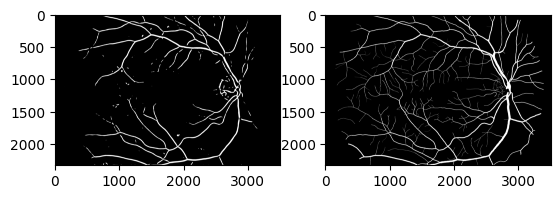

In [34]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(prediction, cmap='gray')
ax[1].imshow(gold_standard, cmap='gray')

***Machine learning part***

**Create function to print ML statistics**

In [35]:
from sklearn.metrics import confusion_matrix

def print_statistics(ideal, predicted):
    print(len(confusion_matrix(ideal, predicted).ravel()))
    print(confusion_matrix(ideal,predicted))
    tn, fp, fn, tp = confusion_matrix(ideal, predicted).ravel()
    
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print('accuracy: {}'.format(accuracy))
    print('sensitivity: {}'.format(sensitivity))
    print('specificity {}'.format(specificity))  

**Example split into 5x5 fragments**

In [36]:
from skimage.util.shape import view_as_windows

img = io.imread('manual1/04_h.tif')
img_5_5_blocks = view_as_windows(img, (5, 5))
print(type(img_5_5_blocks))
print(img_5_5_blocks.shape)
print(img.shape)
print(img_5_5_blocks[0][0])

<class 'numpy.ndarray'>
(2332, 3500, 5, 5)
(2336, 3504)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


**Create data and split into training and test sets**

In [37]:
import os
from sklearn.model_selection import train_test_split
from statistics import mean, stdev
from random import randrange

images = [os.path.join('images',file) for file in os.listdir('images')]
expert_masks = [os.path.join('manual1',file) for file in os.listdir('manual1')]

data = []
labels = []
size = 100_000
num_images = 3
for i in range(num_images):
    print(i)
    image = io.imread(images[i], as_gray=True)
    mask = io.imread(expert_masks[i], as_gray=True)
    images_5_5 = view_as_windows(image, (5, 5))
    masks_5_5 = view_as_windows(mask, (5, 5))

    for s in range(size//num_images):
        j = randrange(len(images_5_5))
        k = randrange(len(images_5_5))
        curr_img = images_5_5[j][k]
        curr_mask = masks_5_5[j][k]
        
        central_pixel = curr_mask[2][2]
        avg = mean(curr_img.reshape(-1))
        dev = stdev(curr_img.reshape(-1))

        data.append([avg, dev])
        labels.append(central_pixel)
        
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.33, random_state=42)
print(len(X_train), len(X_test))

0
1
2
66999 33000


**Perform undersampling**

In [38]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print('Training labels %s' % Counter(y_train))
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Training labels after undersampling %s' % Counter(y_res))

Training labels Counter({0: 62147, 255: 4852})
Training labels after undersampling Counter({0: 4852, 255: 4852})


**Create classifier and train our model**

In [39]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_res, y_res)

RandomForestClassifier()

**Predict result on test data**

In [40]:
y_pred = rfc.predict(X_test)
print('Predicted labels %s' % Counter(y_pred))

Predicted labels Counter({0: 23026, 255: 9974})


**Compare it with test data and print stats**

In [41]:
print('Statistics on test data')
print_statistics(y_test, y_pred)

Statistics on test data
4
[[22380  8080]
 [  646  1894]]
accuracy: 0.7355757575757575
sensitivity: 0.7456692913385827
specificity 0.7347340774786605


**Test our model on new image**

finished creating metrics
staring predicting
finished predicting


C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


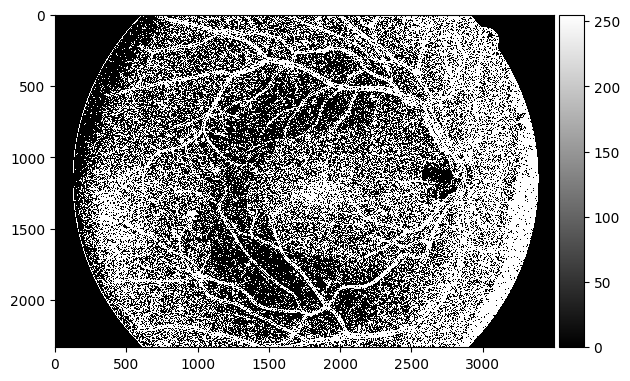

In [42]:
new_image = io.imread(image_name, as_gray=True)
fragments = view_as_windows(new_image, (5, 5))

metrics = []
for i in range(len(fragments)):
    for j in range(len(fragments[0])):
        square = fragments[i][j]
        average = mean(square.reshape(-1))
        stand_dev = stdev(square.reshape(-1))
        metrics.append([average, stand_dev])

print('finished creating metrics')
print('staring predicting')
predictions = rfc.predict(metrics)
print('finished predicting')
predicted_image = predictions.reshape(fragments.shape[0], fragments.shape[1])
        
io.imshow(predicted_image, cmap='gray')

**Resize ideal image to the same shape (remove border)**

In [43]:
perfect_image = io.imread(gold_standard_name)
bottom = len(perfect_image) - 2
right = len(perfect_image[0]) - 2
without_border = perfect_image[2:bottom, 2:right]

**Gold standard vs predicted image**

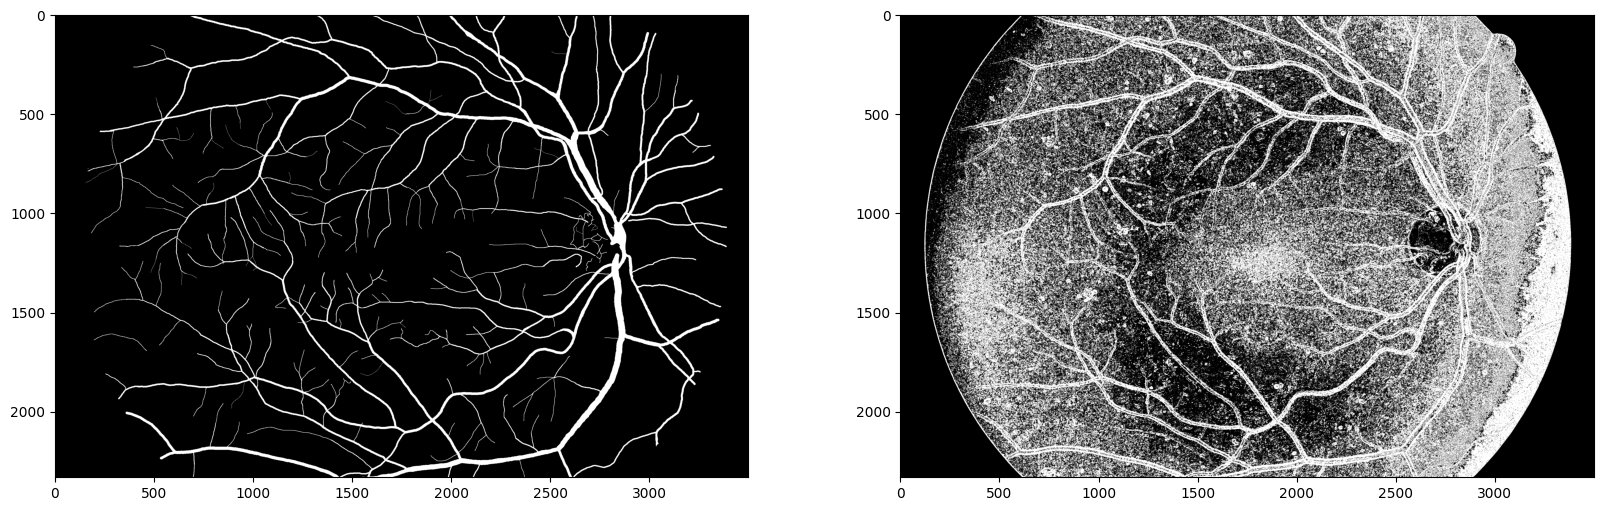

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].imshow(without_border, cmap='gray')
ax[1].imshow(predicted_image, cmap='gray')

**Calculate and display statistics**

In [45]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(without_border.shape[0]):
    for j in range(without_border.shape[1]):
        if without_border[i][j] == 0 and predicted_image[i][j] == 0:
            tn += 1
        if without_border[i][j] == 0 and predicted_image[i][j] == 255:
            fp += 1
        if without_border[i][j] == 255 and predicted_image[i][j] == 0:
            fn += 1
        if without_border[i][j] == 255 and predicted_image[i][j] == 255:
            tp += 1

accuracy = (tp + tn) / (tn + fp + fn + tp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print('accuracy: {}'.format(accuracy))
print('sensitivity: {}'.format(sensitivity))
print('specificity {}'.format(specificity))

accuracy: 0.6067129380053908
sensitivity: 0.7691103303906012
specificity 0.5956360232639678


**Gold standard vs processed image vs machine learning**

[(-0.5, 3503.5, 2335.5, -0.5),
 (-0.5, 3503.5, 2335.5, -0.5),
 (-0.5, 3499.5, 2331.5, -0.5)]

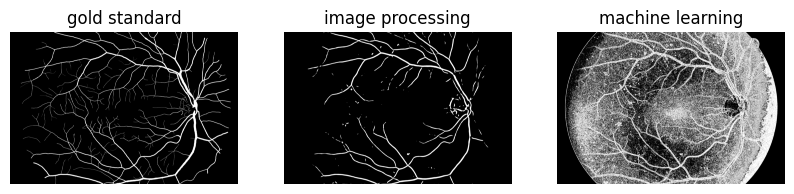

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(10, 20))

ax[0].imshow(perfect_image, cmap='gray')
ax[0].set_title('gold standard')
ax[1].imshow(prediction, cmap='gray')
ax[1].set_title('image processing')
ax[2].imshow(predicted_image, cmap='gray')
ax[2].set_title('machine learning')
[ax[i].axis('off') for i in range(3)]

**Display statistics for comparison**

In [47]:
print('Stats for image processing')
print(acc)
print(sens)
print(spec)
print('Stats for ML')
print('accuracy: {}'.format(accuracy))
print('sensitivity: {}'.format(sensitivity))
print('specificity {}'.format(specificity))

Stats for image processing
95.92040358963533
0.5500959994481469
0.9870640777945645
Stats for ML
accuracy: 0.6067129380053908
sensitivity: 0.7691103303906012
specificity 0.5956360232639678
